# 0. Importing Required Libraries

In [1]:
!pip install catboost

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from scipy.stats import ttest_ind, zscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor



#plt.style.use("fivethirtyeight")
plt.style.use("ggplot")
#sns.set_style("white")

In [3]:
class cfg:
    figsize = (10,6)
    csv_path = "insurance.csv"
    csv_link = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

In [4]:
if os.path.exists(cfg.csv_path):
  df = pd.read_csv(cfg.csv_path)
else:
  df = pd.read_csv(cfg.csv_link)

# 1. EDA

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Examining the BMI distribution

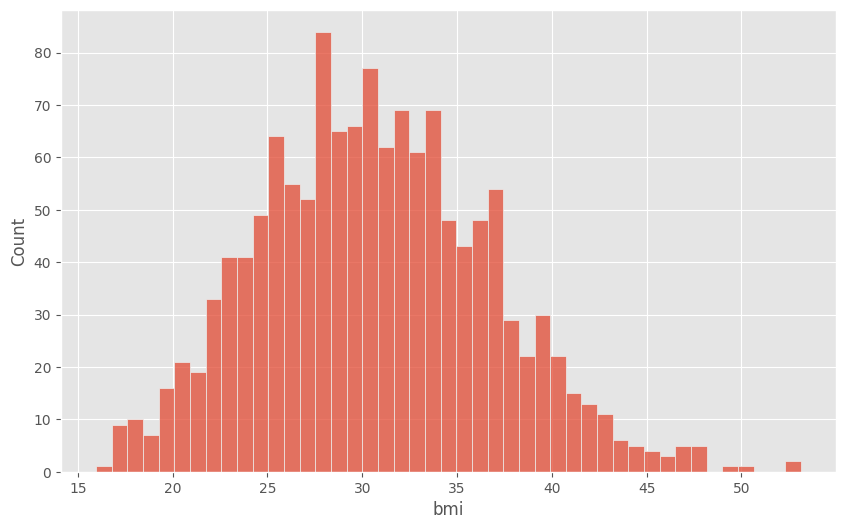

In [6]:
plt.figure(figsize=cfg.figsize)
sns.histplot(data=df, x='bmi',bins=45, )
plt.show()

In [7]:
df.bmi.describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [8]:
df.bmi.skew()
# slightly right skew with almost normal distribution

0.2840471105987448

<Axes: xlabel='bmi'>

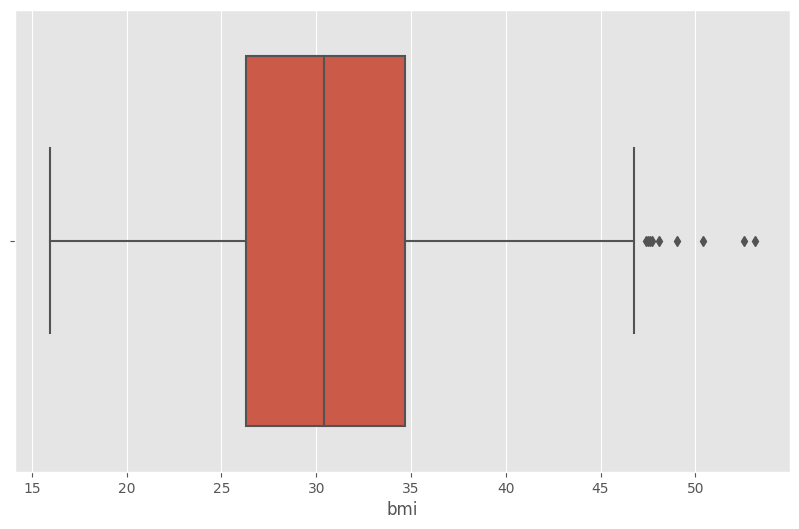

In [9]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x='bmi')

## Examine the relationship between `smoker` and `charges`

<Axes: xlabel='charges', ylabel='smoker'>

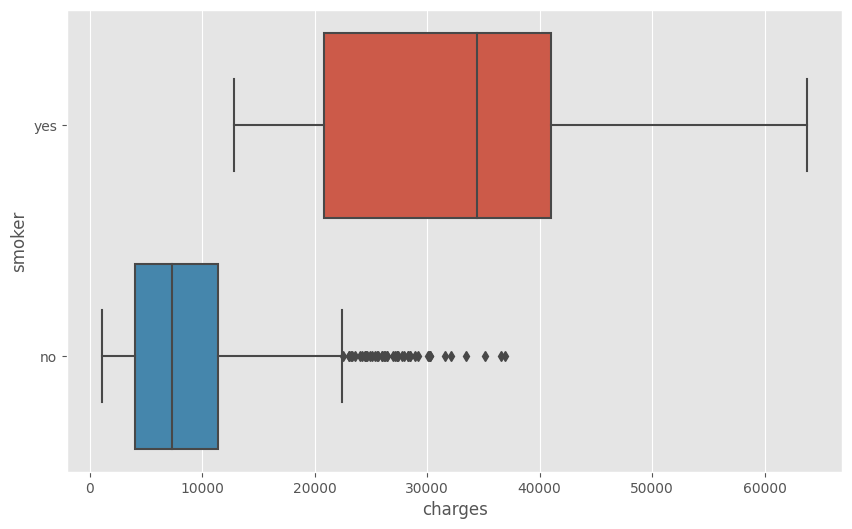

In [10]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x='charges', y='smoker')

In [11]:
df.groupby('smoker')['charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1064.0,8434.268298,5993.781819,1121.8739,3986.438700,7345.40530,11362.887050,36910.60803
yes,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801


As we can see from the statistics and boxplot, smokers, on average, have significantly higher medical charges than non-smokers.

## Examine the relationship between `smoker` and `region`

<Axes: xlabel='region'>

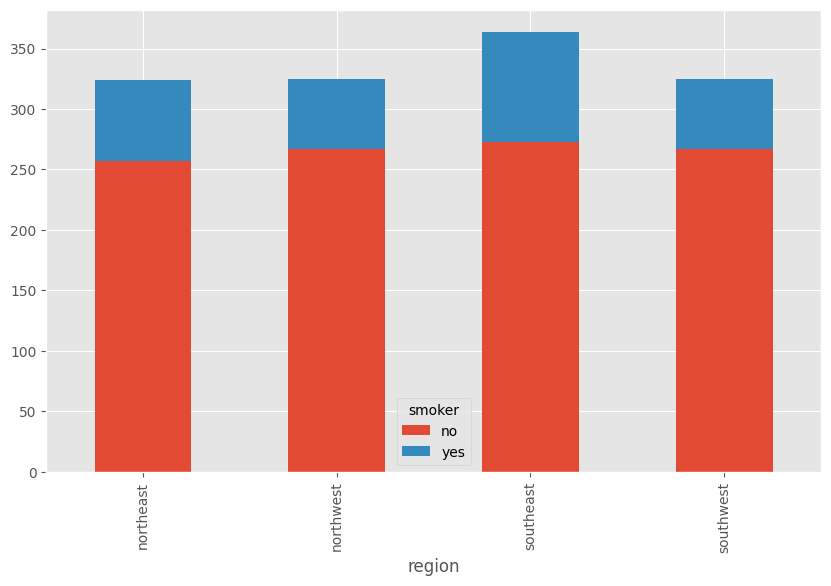

In [12]:
plt.figure(figsize=cfg.figsize)
df.groupby(['region','smoker']).size().unstack().plot(kind='bar', stacked=True, ax=plt.gca())

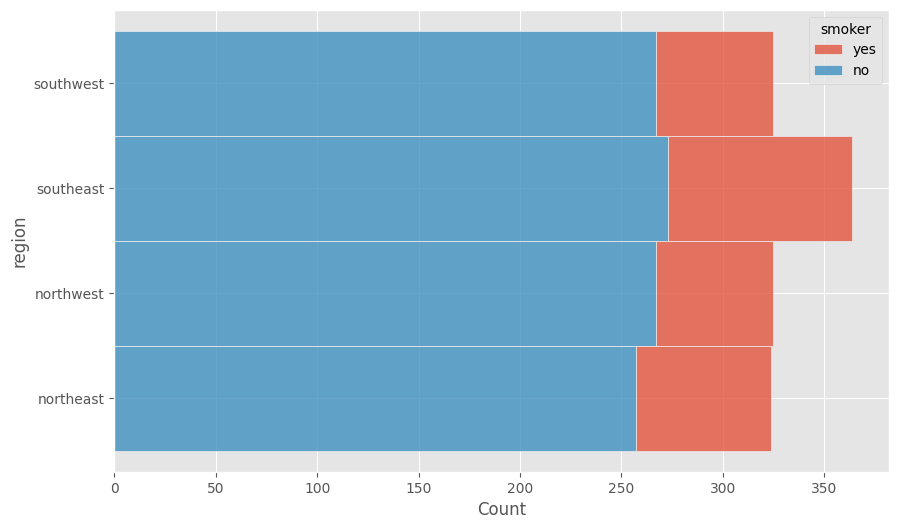

In [13]:
plt.figure(figsize=cfg.figsize)
sns.histplot(data=df, y='region', hue='smoker', multiple='stack', ax=plt.gca())
plt.show()

In [14]:
(df.groupby(['region','smoker']).size() / df.groupby('region').size()).unstack()

smoker,no,yes
region,,
northeast,0.793210,0.206790
northwest,0.821538,0.178462
southeast,0.750000,0.250000
southwest,0.821538,0.178462


From this data, we can say smoker frequencies varies across the different regions, with the Southeast having a noticeably higher rate.

## Examine the relationship between `bmi` and `sex`

In [15]:
df.groupby('sex').describe()['bmi']

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,30.377749,6.046023,16.815,26.125,30.1075,34.31375,48.07
male,676.0,30.943129,6.140435,15.960,26.410,30.6875,34.99250,53.13


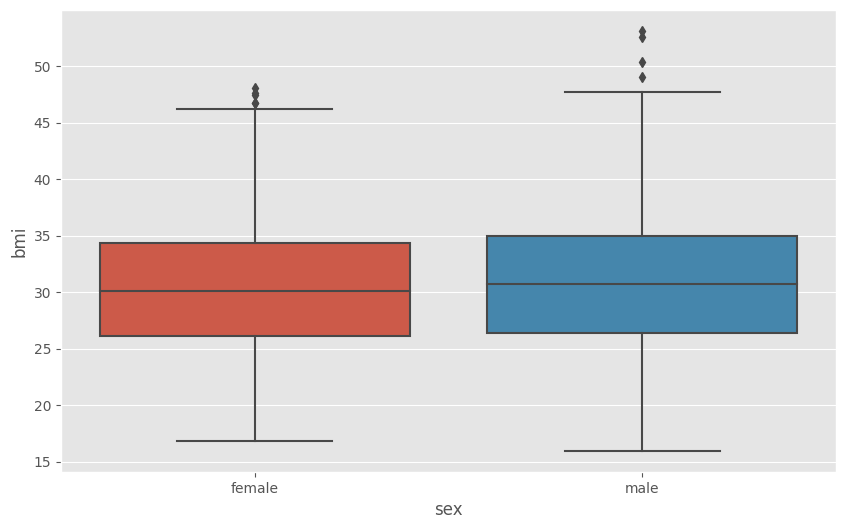

In [16]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x ='sex', y='bmi')
plt.show()

At first glance, there doesn't seem to be a significant difference between male and female bmi values.

In [17]:
male_bmi = df[df['sex'] == 'male']['bmi'].values
female_bmi = df[df['sex'] == 'female']['bmi'].values

p_value = 0.05
ttest_ind(male_bmi, female_bmi)

Ttest_indResult(statistic=1.696752635752224, pvalue=0.08997637178984932)

## Find the `region` with the most `children`

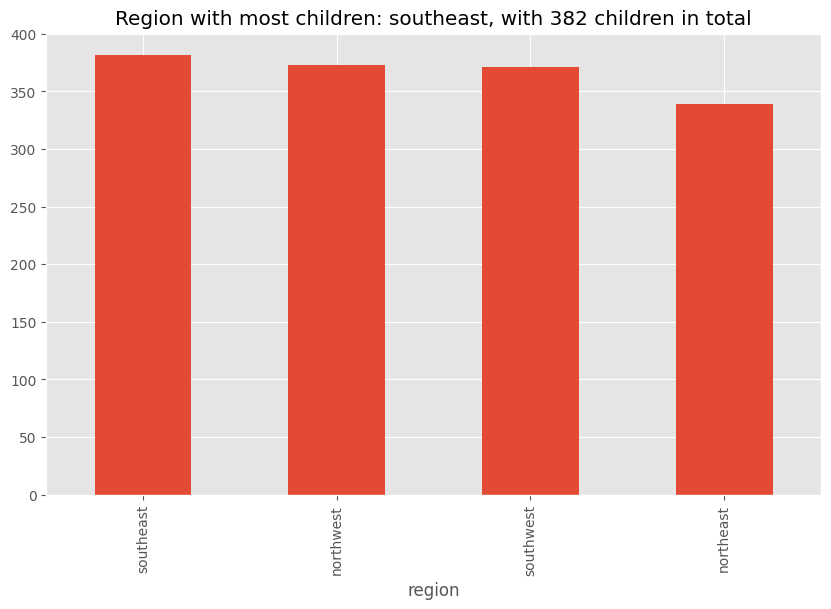

In [18]:
children_region = df.groupby('region')['children'].sum().sort_values(ascending=False)
plt.figure(figsize=cfg.figsize)
plt.title(f"Region with most children: {children_region.index[0]}, with {children_region[0]} children in total")
children_region.plot(kind='bar')
plt.show()

## Examine the relationship between `age` and `bmi`

<Figure size 1000x1000 with 0 Axes>

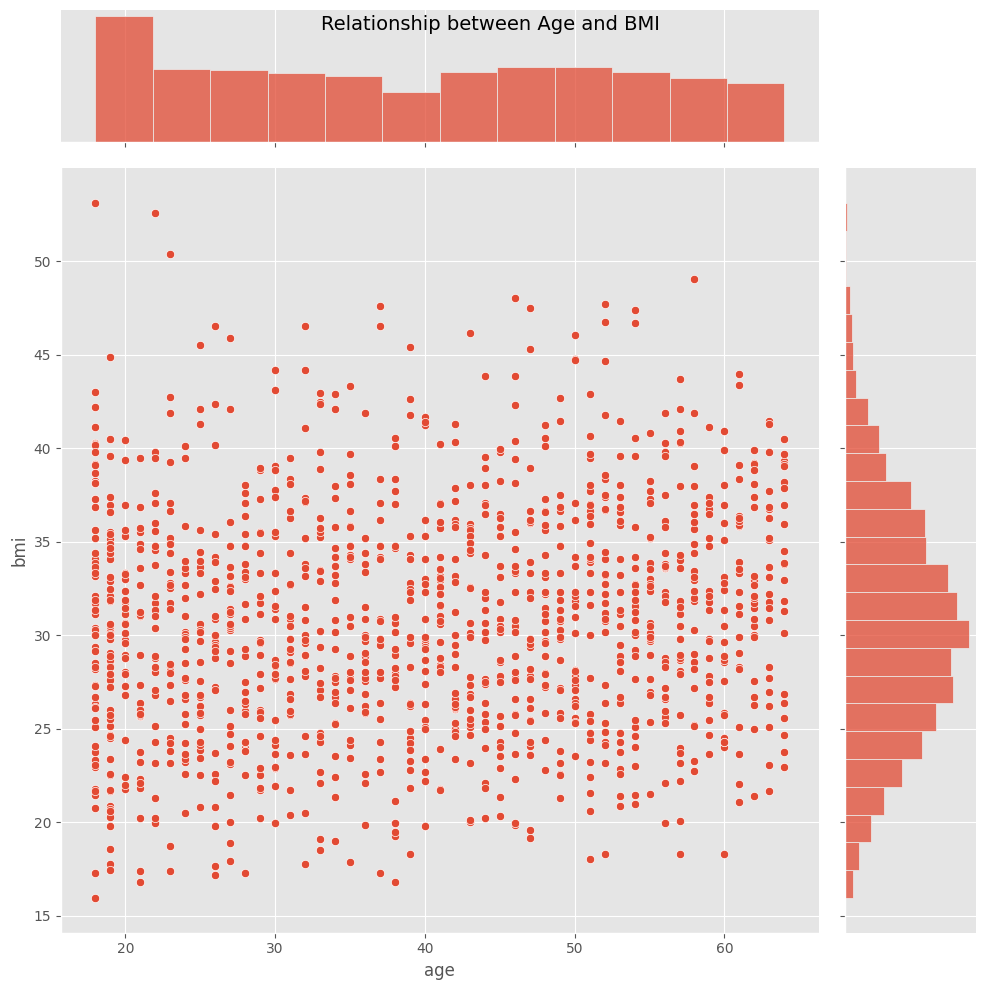

In [19]:
plt.figure(figsize=(10,10))
sns.jointplot(data=df, x='age', y='bmi', height= 10)
plt.suptitle('Relationship between Age and BMI', fontsize=14)
plt.show()

In [20]:
# Plot shows that while BMI values vary across all ages
# there is no clear trend or pattern indicating a strong
# association between age and BMI, and in fact
# also the correlation between age and BMI is low.
print(f"Correlation of Age-BMI: {df['age'].corr(df['bmi']):.4f}")

Correlation of Age-BMI: 0.1093


## Examine the relationship between `bmi` and `children`

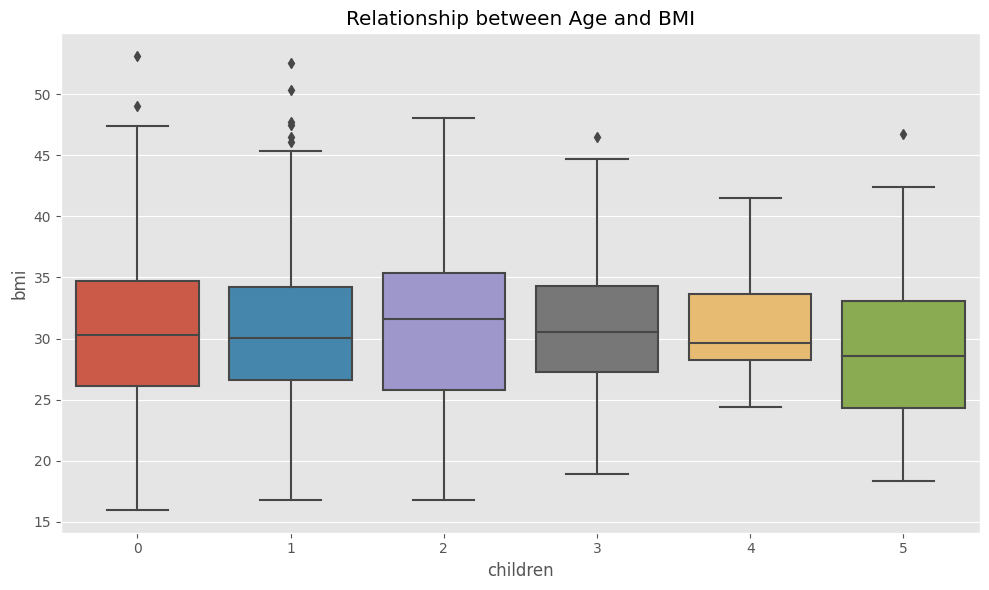

In [21]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x='children', y='bmi',)
plt.title('Relationship between Age and BMI', )
plt.tight_layout()
plt.show()

In [22]:
print(f"Correlation betwween BMI and Children is: {(df.bmi.corr(df.children)):.4f}")

Correlation betwween BMI and Children is: 0.0128


## Any outliers on the `bmi` variable?

We'll identify outliers using the Z-score formula:

$$Z = \frac{X - \mu}{\sigma}$$

In this context, any data point with a Z-score greater than 3 or less than -3 is considered an outlier.

In [23]:
bmi_mean = df.bmi.mean()
bmi_std = df.bmi.std()
z_scores = (df.bmi - bmi_mean) / bmi_std
z_score_threshold = 3
bmi_outliers_z = df[np.abs(z_scores) > z_score_threshold]

bmi_outliers_z

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.3254
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


### and the Interquartile Range (IQR)

The Interquartile Range (IQR) is a statistical measure of spread or dispersion that indicates the difference in a dataset's upper and lower quartiles. It is used to calculate the statistical spread of the data's middle 50%.

Steps for outlier detection with IQR:
1. Calculate the first and third quartiles
2. Compute the IQR
3. Determine the bounds
4. Identify the outliers

In [24]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)

IQR_value = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR_value
upper_bound = Q3 + 1.5 * IQR_value

bmi_outliers_iqr = df[(df['bmi'] < lower_bound) | (df['bmi'] > upper_bound)]

bmi_outliers_iqr

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


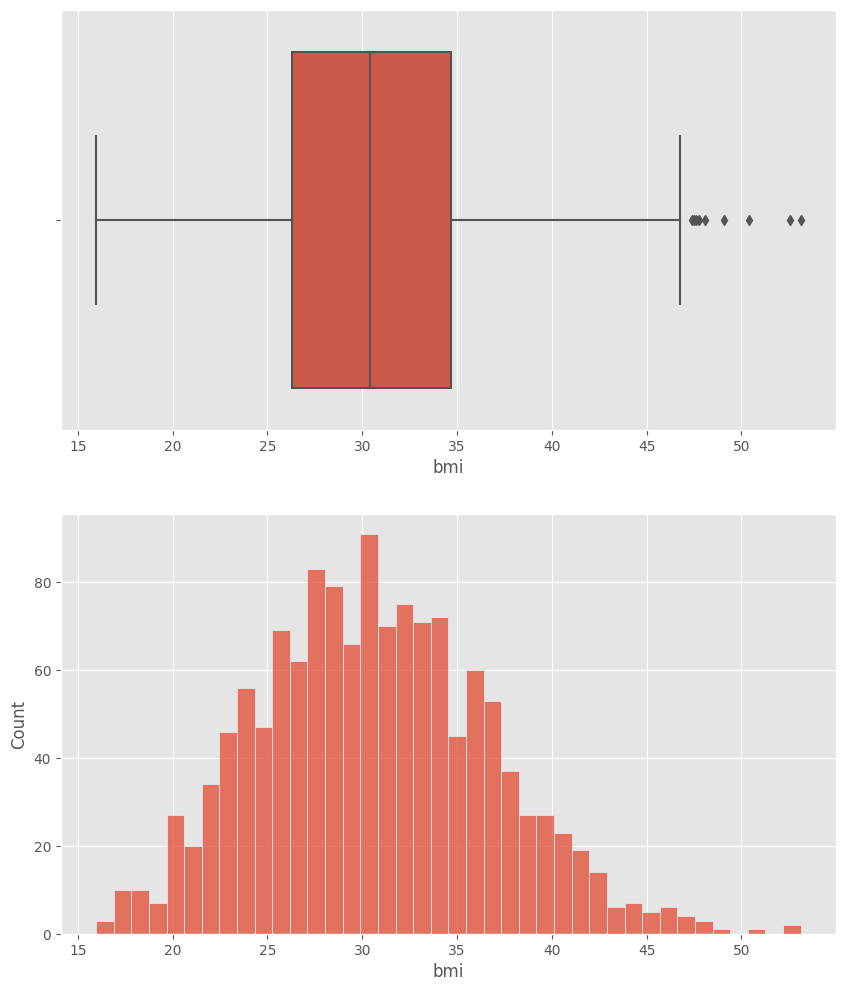

In [25]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(10,12))

sns.boxplot(data=df, x='bmi', ax=axes[0])
sns.histplot(data=df, x='bmi', bins=40, ax=axes[1])
plt.show()

In [26]:
print(f"We have {bmi_outliers_iqr.shape[0]} outliers in the bmi variable ")

We have 9 outliers in the bmi variable 


## Examine the relationship between `bmi` and `charges`

In [27]:
bmi_charges_corr = df.bmi.corr(df.charges)

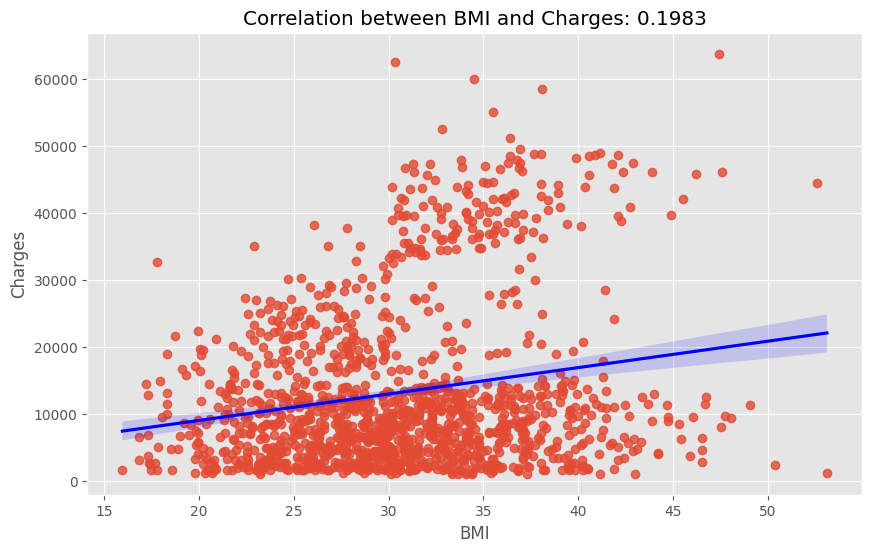

In [28]:
plt.figure(figsize=cfg.figsize)
sns.regplot(data=df, x='bmi', y='charges', line_kws={'color':'blue'})
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title(f"Correlation between BMI and Charges: {bmi_charges_corr:.4f}")
plt.show()

There is a slight positive curve in the bmi and charges relationship.

## Examine the relationship between `region`, `smoker` and `bmi` using bar plot

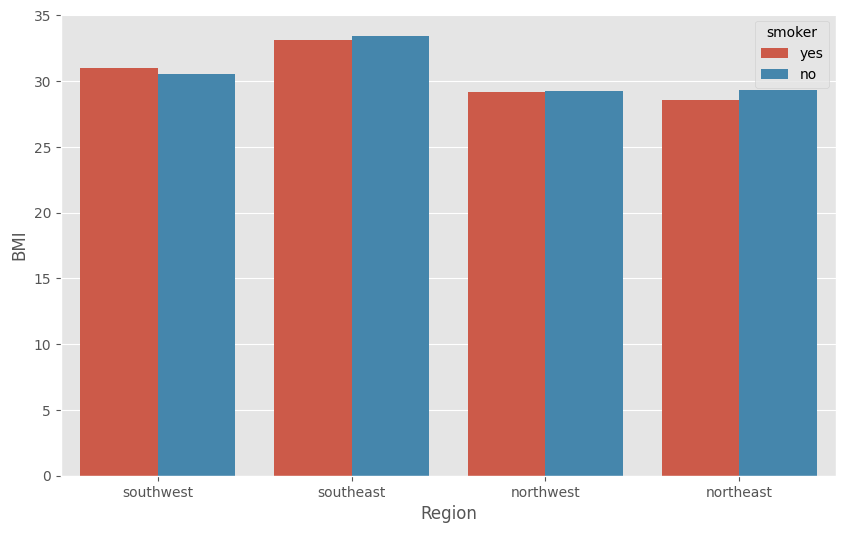

In [29]:
plt.figure(figsize=cfg.figsize)
sns.barplot(data=df, x='region', y='bmi', hue='smoker', errorbar=None)
plt.xlabel("Region")
plt.ylabel('BMI')
plt.show()

 Southeast region has the highest BMI on both smokers and non-smokers. There is no clear indication of smokers has higher BMI in this dataset, as seen as in jointplot below.

<Figure size 1000x600 with 0 Axes>

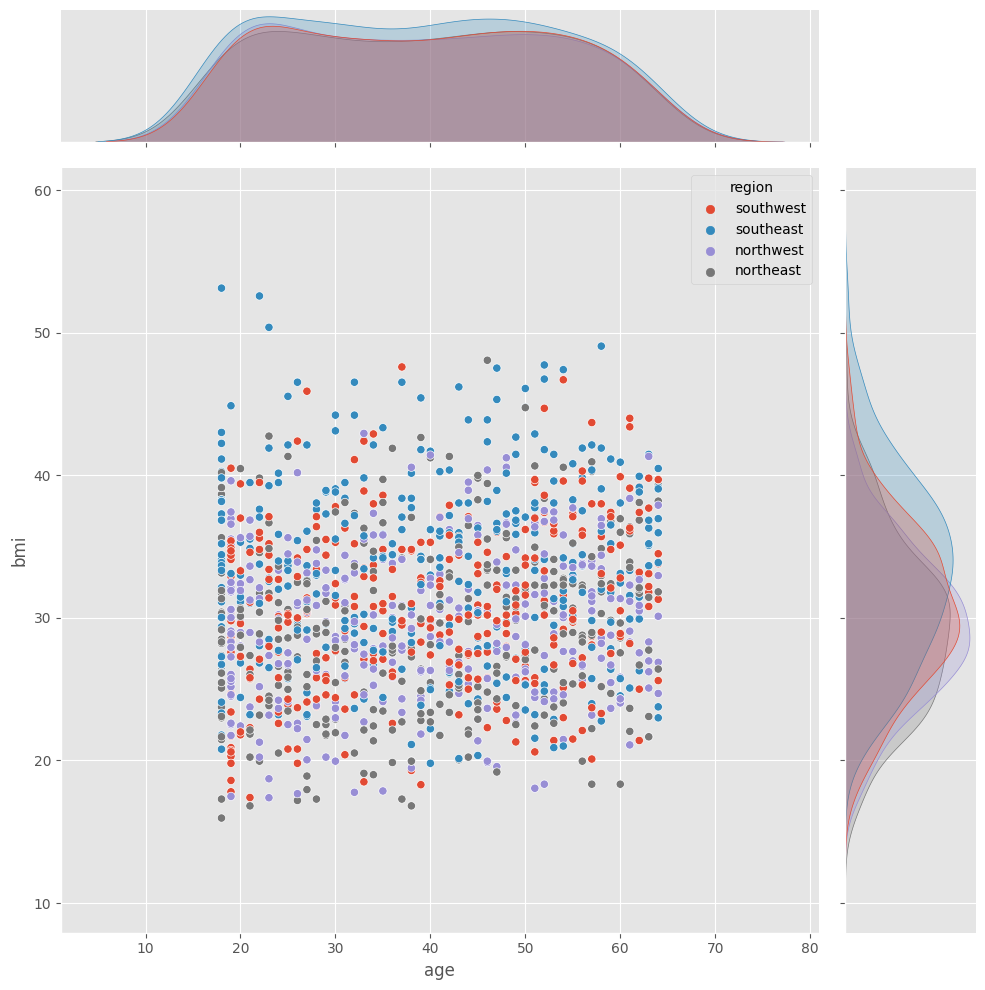

In [30]:
plt.figure(figsize=cfg.figsize)
sns.jointplot(data=df, x='age', y='bmi', hue='region', height= 10, )
plt.show()

# 2. Data Preprocessing

In [31]:
# dropping the outliers in the bmi
df = df.drop(bmi_outliers_iqr.index)

Converting bmi into a categorical data with:

- Less than 18.5: Underweight
- 18.5 to 24.9: Healthy weight
- 25 to 29.9: Overweight
- 30 to 40: Obesity
- Above 40: Severe obesity

Source: [NIH](https://www.niddk.nih.gov/health-information/health-statistics/overweight-obesity)

In [32]:
def bmi_cat(bmi_value):
    if bmi_value < 18.5:
        return "Underweight"
    elif 18.5 <= bmi_value <= 24.9:
        return "Healthy weight"
    elif 25 <= bmi_value <= 29.9:
        return "Overweight"
    elif 30 <= bmi_value <= 40:
        return "Obesity"
    elif 40 < bmi_value :
        return "Severe obesity"

In [33]:
df['bmi'] = df['bmi'].apply(bmi_cat)

In [34]:
# creating pipeline for transforming data

cat_cols = ['smoker', 'region', 'sex', 'bmi']

cat_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical columns', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [35]:
X = pipeline.fit_transform(df.drop('charges', axis=1))
y = df.charges.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Model Selection and Optimization

In [37]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score

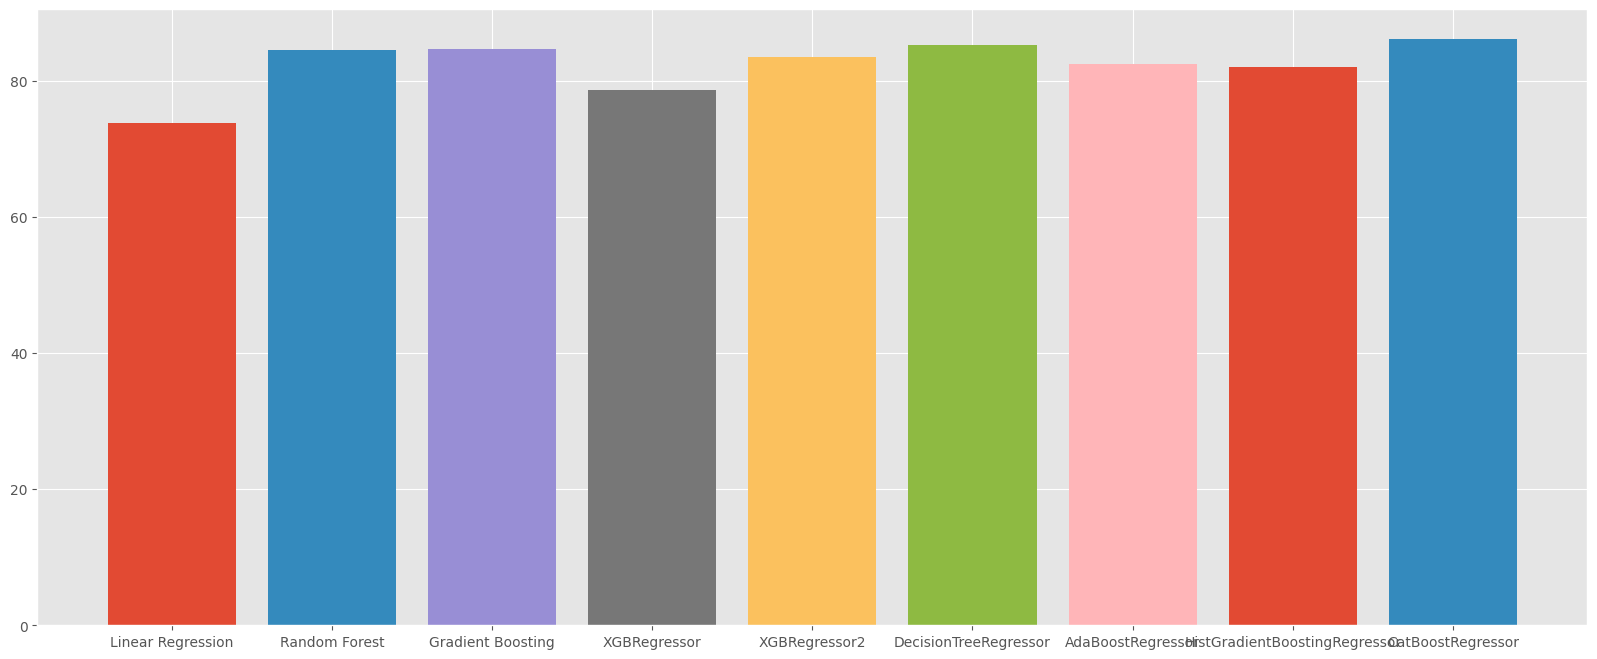

In [38]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(max_depth=7, n_estimators=1200),
    "Gradient Boosting": GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate =.2),
    "XGBRegressor": XGBRegressor(max_depth = 5, n_estimators=750, learning_rate =.05),
    "XGBRegressor2": XGBRegressor(max_depth = 5, n_estimators=1000, learning_rate =.01),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=5,),
    "AdaBoostRegressor": AdaBoostRegressor(learning_rate=0.01, n_estimators=500),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(learning_rate=0.01, max_iter=500, l2_regularization=0.0005),
    "CatBoostRegressor": CatBoostRegressor(learning_rate =.01, max_depth =3, verbose = 0)
}


cv_scores = {}
test_values = {}

for name, model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores[name] = score.mean()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)
    test_values[name] = R2

    plt.rcParams['figure.figsize'] = (20,8)
    plt.bar(name, round(R2,4)*100)


best_model_name = min(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]



In [39]:
result = pd.DataFrame(data=cv_scores.values(), index=cv_scores.keys(), columns=['R2'])
result.sort_values(by='R2')


,R2
Linear Regression,0.746540
XGBRegressor,0.797007
AdaBoostRegressor,0.819004
HistGradientBoostingRegressor,0.820890
DecisionTreeRegressor,0.833020
XGBRegressor2,0.833571
Random Forest,0.840011
Gradient Boosting,0.841832
CatBoostRegressor,0.852366


In [40]:
test_result = pd.DataFrame(data=test_values.values(), index=test_values.keys(), columns=['R2'])
test_result.sort_values(by='R2')


,R2
Linear Regression,0.738645
XGBRegressor,0.786936
HistGradientBoostingRegressor,0.820126
AdaBoostRegressor,0.825010
XGBRegressor2,0.835346
Random Forest,0.845297
Gradient Boosting,0.846700
DecisionTreeRegressor,0.853069
CatBoostRegressor,0.862478


In [41]:
best_model_name, cv_scores


('Linear Regression',
 {'Linear Regression': 0.746540282059763,
  'Random Forest': 0.8400106891616177,
  'Gradient Boosting': 0.8418319446622533,
  'XGBRegressor': 0.7970073037233849,
  'XGBRegressor2': 0.8335711007448652,
  'DecisionTreeRegressor': 0.8330201951264783,
  'AdaBoostRegressor': 0.8190042764200873,
  'HistGradientBoostingRegressor': 0.820890318681591,
  'CatBoostRegressor': 0.8523658805508634})

In [42]:
lr_params = {}
rf_params = {"max_depth": 7, "n_estimators": 1200}
gb_params = {"max_depth": 2, "n_estimators": 100, "learning_rate": 0.2}
xgb_params = {"max_depth": 5, "n_estimators": 750, "learning_rate": 0.05}
xgb2_params = {"max_depth": 5, "n_estimators": 1000, "learning_rate": 0.01}
dt_params = {"max_depth": 5}
ada_params = {"learning_rate": 0.01, "n_estimators": 500}
hgb_params = {"learning_rate": 0.01, "max_iter": 500, "l2_regularization": 0.0005}
cat_params = {"learning_rate": 0.01, "max_depth": 3, "verbose": 0}


models = {
    "Linear Regression": LinearRegression(**lr_params),
    "Random Forest": RandomForestRegressor(**rf_params),
    "Gradient Boosting": GradientBoostingRegressor(**gb_params),
    "XGBRegressor": XGBRegressor(**xgb_params),
    "XGBRegressor2": XGBRegressor(**xgb2_params),
    "DecisionTreeRegressor": DecisionTreeRegressor(**dt_params),
    "AdaBoostRegressor": AdaBoostRegressor(**ada_params),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(**hgb_params),
    "CatBoostRegressor": CatBoostRegressor(**cat_params)
}

In [43]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# We'll look into R2, MAE, MSE and RMSE metrics
metrics = {
    'R2': 'r2',
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),  # negating to make it consistent with other metrics where higher is better
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)
}


# initializing a dict to storing score variables
all_scores = {
    'Model': [],
    'Metric': [],
    'Train_Score': [],
    'Test_Score': []
}

for name, model in tqdm(models.items(), desc="Training and Evaluating Models"):
    for metric_name, metric in metrics.items():
        # cross-validate the model on the train set
        train_score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)

        # for the test set score, fit the model
        model_instance = model.fit(X_train, y_train)


        if metric_name == 'R2':
             test_score = model_instance.score(X_test, y_test)  # for R^2, we can use the model's score method
        else:
            test_func = metrics[metric_name]._score_func  # getting the current test function from current metric
            test_score = test_func(y_test, model_instance.predict(X_test))

        # de-negate the negated scores
        adjusted_train_score = -train_score.mean() if metric_name in ['MSE', 'MAE', 'RMSE'] else train_score.mean()
        adjusted_test_score = -test_score if metric_name in ['MSE', 'MAE', 'RMSE'] else test_score


        all_scores['Model'].append(name)
        all_scores['Metric'].append(metric_name)
        all_scores['Train_Score'].append(adjusted_train_score)
        all_scores['Test_Score'].append(adjusted_test_score)

# Convert the all_scores dictionary into a DataFrame
all_scores_df_corrected = pd.DataFrame(all_scores)

Training and Evaluating Models: 100%|██████████| 9/9 [03:21<00:00, 22.36s/it]


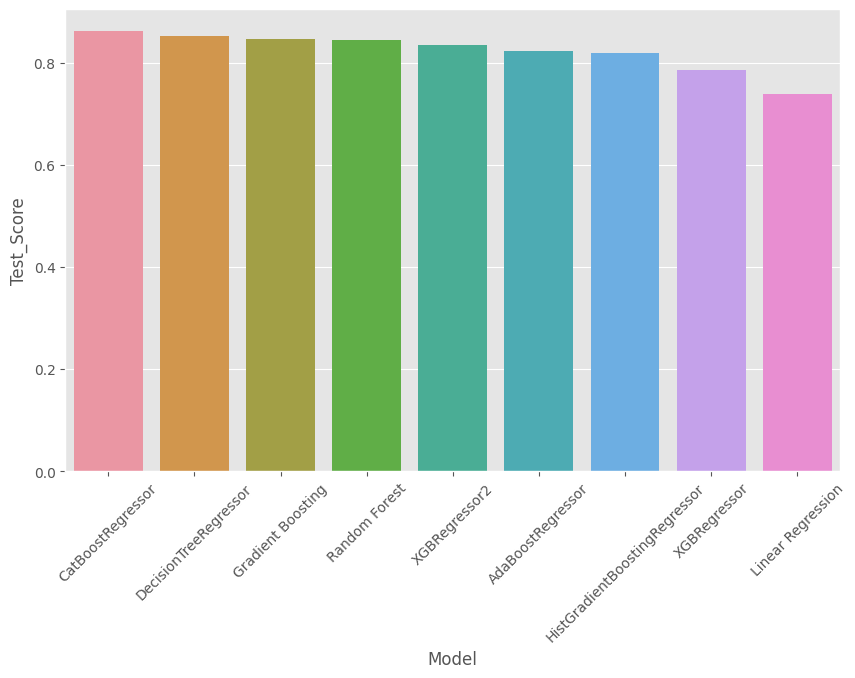

In [45]:
plt.figure(figsize=cfg.figsize)
sns.barplot(data=all_scores_df_corrected[all_scores_df_corrected['Metric'] == 'R2'].sort_values(by='Test_Score', ascending=False), x='Model', y='Test_Score')
plt.xticks(rotation=45)
plt.show()

## Hyperparameter Optimization

In [53]:


model_constructors = {
    "CatBoostRegressor": CatBoostRegressor,
    "DecisionTreeRegressor": DecisionTreeRegressor,
    "GradientBoostingRegressor": GradientBoostingRegressor,
    "RandomForestRegressor": RandomForestRegressor
}

# Define hyperparameter grids for the three models
param_grids = {
    "CatBoostRegressor": {
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "n_estimators": [100, 500, 1500],
        "verbose": [0]
    },
    "DecisionTreeRegressor": {
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "GradientBoostingRegressor": {
        "learning_rate": [0.01, 0.05, 0.1],
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 0.9, 1.0]
    },
    "RandomForestRegressor": {
            'n_estimators': [100, 500, 1000],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [10, 30, 50],
    }

}



best_params = {}

# Perform grid search for each model
for model_name, param_grid in tqdm(param_grids.items(), desc="Hyperparameter Optimization"):
    model_constructor = model_constructors[model_name]
    grid_search = GridSearchCV(model_constructor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Best Score': -grid_search.best_score_  # neg_mean_squared_error
    }


Hyperparameter Optimization:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Hyperparameter Optimization:  25%|██▌       | 1/4 [00:48<02:24, 48.23s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Hyperparameter Optimization:  50%|█████     | 2/4 [00:48<00:40, 20.08s/it]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Hyperparameter Optimization:  75%|███████▌  | 3/4 [01:45<00:36, 36.84s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Hyperparameter Optimization: 100%|██████████| 4/4 [04:14<00:00, 63.72s/it]


In [65]:
optimized_models = [
    ('DecisionTreeRegressor', DecisionTreeRegressor(**best_params['DecisionTreeRegressor']['Best Parameters'])),
    ('GradientBoostingRegressor', GradientBoostingRegressor(**best_params['GradientBoostingRegressor']['Best Parameters'])),
    #('RandomForestRegressor', RandomForestRegressor(**best_params['RandomForestRegressor']['Best Parameters'])),
    ('RandomForestRegressor', RandomForestRegressor(**rf_params)),
     ('CatBoostRegressor', CatBoostRegressor(**cat_params)),


]

In [66]:
# initialize a ensemble model and fit
ensemble_regressor = VotingRegressor(estimators=optimized_models)
ensemble_regressor.fit(X_train, y_train)

# predict the test data with the ensemble model
ensemble_test_predictions = ensemble_regressor.predict(X_test)



In [68]:
r2 = r2_score(y_test, ensemble_test_predictions)
mae = mean_absolute_error(y_test, ensemble_test_predictions)
mse = mean_squared_error(y_test, ensemble_test_predictions)
rmse = root_mean_squared_error(y_test, ensemble_test_predictions)

# visualize the metrics in a DataFrame
ensemble_metrics_df = pd.DataFrame({
    'Metric': ['R2', 'MAE', 'MSE', 'RMSE'],
    'Value': [r2, mae, mse, rmse]
})

ensemble_metrics_df

,Metric,Value
0,R2,8.607443e-01
1,MAE,2.462838e+03
2,MSE,1.863184e+07
3,RMSE,4.316461e+03
